In [4]:
import json
import math
import os,shutil

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(2019)
tf.set_random_seed(2019)

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

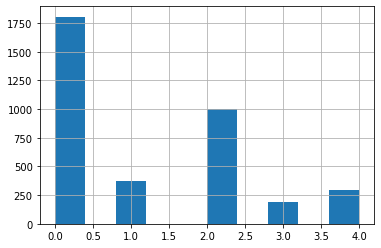

In [4]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

In [5]:
x_train,x_valid= train_test_split(train_df,
                                  stratify = train_df['diagnosis'],
                                  test_size = 0.20,
                                random_state = 2019)

0    1444
2     799
1     296
4     236
3     154
Name: diagnosis, dtype: int64

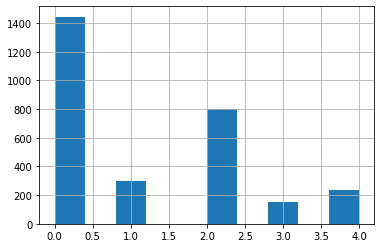

In [6]:
x_train['diagnosis'].hist()
x_train['diagnosis'].value_counts()

In [7]:
def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

In [11]:
def preprocess_image(image_path, desired_size=256):
    im = Image.open(image_path) 
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [12]:
x_0 = np.empty((len(x_train[x_train['diagnosis'] == 0]), 256, 256, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(x_train[x_train['diagnosis'] == 0]['id_code'])):
    x_0[i, :, :, :] = preprocess_image(
        f'train_images/{image_id}.png'
    )

100%|██████████| 1444/1444 [02:02<00:00, 11.79it/s]


In [13]:
np.save('x0',x_0)

In [14]:
x_1 = np.empty((len(x_train[x_train['diagnosis'] == 1]), 256, 256, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(x_train[x_train['diagnosis'] == 1]['id_code'])):
    x_1[i, :, :, :] = preprocess_image(
        f'train_images/{image_id}.png'
    )
np.save('x1',x_1)

100%|██████████| 296/296 [00:51<00:00,  5.55it/s]


In [15]:
x_2 = np.empty((len(x_train[x_train['diagnosis'] == 2]), 256, 256, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(x_train[x_train['diagnosis'] == 2]['id_code'])):
    x_2[i, :, :, :] = preprocess_image(
        f'train_images/{image_id}.png'
    )
np.save('x2',x_2)

100%|██████████| 799/799 [02:35<00:00,  4.57it/s]


In [16]:
x_3 = np.empty((len(x_train[x_train['diagnosis'] == 3]), 256, 256, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(x_train[x_train['diagnosis'] == 3]['id_code'])):
    x_3[i, :, :, :] = preprocess_image(
        f'train_images/{image_id}.png'
    )
np.save('x3',x_3)

100%|██████████| 154/154 [00:29<00:00,  4.81it/s]


In [17]:
x_4 = np.empty((len(x_train[x_train['diagnosis'] == 4]), 256, 256, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(x_train[x_train['diagnosis'] == 4]['id_code'])):
    x_4[i, :, :, :] = preprocess_image(
        f'train_images/{image_id}.png'
    )
np.save('x4',x_4)

100%|██████████| 236/236 [00:46<00:00,  5.39it/s]


In [3]:
# x_1 = np.load('x1.npy')
# x_2 = np.load('x2.npy')
# x_3 = np.load('x3.npy')
# x_4 = np.load('x4.npy')

In [33]:
y_0 = np.expand_dims(x_train[x_train['diagnosis'] == 0]['diagnosis'],1)

In [23]:
y_1 = np.expand_dims(x_train[x_train['diagnosis'] == 1]['diagnosis'],1)
y_2 = np.expand_dims(x_train[x_train['diagnosis'] == 2]['diagnosis'],1)
y_3 = np.expand_dims(x_train[x_train['diagnosis'] == 3]['diagnosis'],1)
y_4 = np.expand_dims(x_train[x_train['diagnosis'] == 4]['diagnosis'],1)
y_1.shape,y_2.shape,y_3.shape,y_4.shape

((296, 1), (799, 1), (154, 1), (236, 1))

**-----------------------Oversampling SMOTE------------------------------------**

In [19]:
from imblearn.over_sampling import SMOTE

In [24]:
x_1_2 = np.vstack((x_1,x_2))
y_1_2 = np.vstack((y_1,y_2))
x_1_2.shape,y_1_2.shape

((1095, 256, 256, 3), (1095, 1))

In [25]:
smote = SMOTE(ratio='minority')
X_sm_1_2, y_sm_1_2 = smote.fit_sample(x_1_2.reshape((len(x_1_2),-1)), y_1_2)

In [26]:
np.save('X_sm_1_2',X_sm_1_2)
np.save('y_sm_1_2',y_sm_1_2)

In [27]:
x_3_2 = np.vstack((x_3,x_2))
y_3_2 = np.vstack((y_3,y_2))
x_3_2.shape,y_3_2.shape

((953, 256, 256, 3), (953, 1))

In [28]:
X_sm_3_2, y_sm_3_2 = smote.fit_sample(x_3_2.reshape((len(x_3_2),-1)), y_3_2)
np.save('X_sm_3_2',X_sm_3_2)
np.save('y_sm_3_2',y_sm_3_2)

In [29]:
x_4_2 = np.vstack((x_4,x_2))
y_4_2 = np.vstack((y_4,y_2))
x_4_2.shape,y_4_2.shape
X_sm_4_2, y_sm_4_2 = smote.fit_sample(x_4_2.reshape((len(x_4_2),-1)), y_4_2)
np.save('X_sm_4_2',X_sm_4_2)
np.save('y_sm_4_2',y_sm_4_2)

In [36]:
y_sm_1_2 = np.expand_dims(y_sm_1_2,1)
y_sm_3_2 = np.expand_dims(y_sm_3_2,1)
y_sm_4_2 = np.expand_dims(y_sm_4_2,1)

In [37]:
labels = np.vstack((y_0,y_sm_1_2,y_sm_3_2,y_sm_4_2))
labels.shape

(6238, 1)

(array([1444.,    0.,  799.,    0.,    0., 2397.,    0.,  799.,    0.,
         799.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

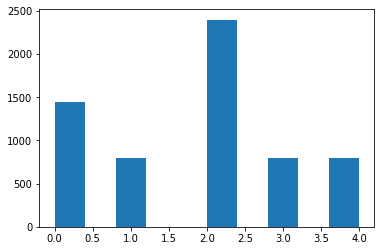

In [38]:
plt.hist(labels)

In [41]:
X_sm_1_2 = X_sm_1_2.reshape((-1,256,256,3))
X_sm_3_2 = X_sm_3_2.reshape((-1,256,256,3))
X_sm_4_2 = X_sm_4_2.reshape((-1,256,256,3))

In [43]:
X_tr = np.vstack((x_0,X_sm_1_2,X_sm_3_2,X_sm_4_2))
X_tr.shape

(6238, 256, 256, 3)

In [ ]:
# N = test_df.shape[0]
# x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

# for i, image_id in enumerate(tqdm(test_df['id_code'])):
#     x_test[i, :, :, :] = preprocess_image(
#         f'test_images/{image_id}.png'
#     )

In [47]:
y_train = pd.get_dummies(np.squeeze(labels)).values

print(X_tr.shape)
print(y_train.shape)
# print(x_test.shape)

(6238, 256, 256, 3)
(6238, 5)


In [48]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1444  799 2397  799  799]
Multilabel version: [6238 4794 3995 1598  799]


In [49]:
x_train, x_val, y_train, y_val = train_test_split(
    X_tr, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

In [50]:
del X_sm_1_2,X_sm_3_2,X_sm_4_2,y_sm_1_2,y_sm_3_2,y_sm_4_2,x_0,x_1,x_2,x_3,x_4,y_0,y_1,y_2,y_3,y_4,x_valid

In [51]:
np.save('x_train',x_train)
np.save('x_val',x_val)
np.save('y_train',y_train)
np.save('y_val',y_val)

**-------------------------------------- Load saved image --------------------------**

In [8]:
x_train = np.load('x_train.npy')
x_val = np.load('x_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')

In [9]:
x_train.shape

(5302, 256, 256, 3)

**---------------------------- DO Subtract median bg image -----------------------**

In [10]:
for i in tqdm(range(len(x_train))):
    x_train[i] = subtract_median_bg_image(x_train[i])
x_train.shape

100%|██████████| 5302/5302 [00:25<00:00, 208.13it/s]


(5302, 256, 256, 3)

In [11]:
for i in tqdm(range(len(x_val))):
    x_val[i] = subtract_median_bg_image(x_val[i])
x_val.shape

100%|██████████| 936/936 [00:04<00:00, 210.04it/s]


(936, 256, 256, 3)

In [12]:
BATCH_SIZE = 16

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [13]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model_256_os_sm_retina_best.h5')

        return

In [14]:
densenet = DenseNet121(
    weights='retina_weights.best.hdf5',
    include_top=False,
    input_shape=(256,256,3)
)

Instructions for updating:
Colocations handled automatically by placer.


ValueError: You are trying to load a weight file containing 9 layers into a model with 241 layers.

In [18]:
# for layer in densenet.layers[:-5]:
#     layer.trainable = False

In [19]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Dense(256,activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [20]:
model = build_model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 44,037
Non-trainable params: 6,998,592
_________________________________________________________________


In [ ]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
332/331 [==============================] - 75s 226ms/step - loss: 0.6039 - acc: 0.7113 - val_loss: 1.2809 - val_acc: 0.6241
val_kappa: -0.3725
Validation Kappa has improved. Saving model.
Epoch 2/15
332/331 [==============================] - 61s 184ms/step - loss: 0.4367 - acc: 0.8088 - val_loss: 1.3669 - val_acc: 0.6325
val_kappa: -0.3043
Validation Kappa has improved. Saving model.
Epoch 3/15
332/331 [==============================] - 61s 184ms/step - loss: 0.3812 - acc: 0.8333 - val_loss: 1.3868 - val_acc: 0.6526
val_kappa: -0.2437
Validation Kappa has improved. Saving model.
Epoch 4/15
332/331 [==============================] - 61s 184ms/step - loss: 0.3512 - acc: 0.8485 - val_loss: 1.4112 - val_acc: 0.6729
val_kappa: -0.1793
Validation Kappa has improved. Saving model.
Epoch 5/15
332/331 [==============================] - 61s 184ms/step - loss: 0.3295 - acc: 0.8606 - val_loss: 1.4277 - val_acc: 0.6793
val_kappa: -0.1386
Va

In [ ]:
# y_test = model.predict(x_test) > 0.5
# y_test = y_test.astype(int).sum(axis=1) - 1

# test_df['diagnosis'] = y_test
# test_df.to_csv('submission.csv',index=False)